# Redes Neuronales 2020
## Trabajo Práctico 2
### MNIST Auto-Encoder

En este trabajo vamos a implementar un auto-encoder para el dataset de dígitos MNIST para comprender la identidad del mismo.

Para escribir nuestro modelo vamos a utilizar la librería PyTorch y luego realizaremos algunos análisis variando sus parámetros.

In [1]:
try:
    import mnist
except ImportError:
    !pip install import mnist
    import mnist

try:
    from autoclass import autoargs
except ImportError:
    !pip install autoclass
    from autoclass import autoargs

try:
    import ipdb
except ImportError:
    !pip install ipdb
    import ipdb

try:
    from skimage.utils import random_noise
except ImportError:
    !pip install scikit-image
    from skimage.util import random_noise

import torch
import torch.nn
import torch.optim
import torchvision.transforms as T

from tqdm.notebook import tqdm
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

torch.manual_seed(23)
np.random.seed(23)

### Auto Encoder

Comenzamos por escribir nuestro auto-encoder. Recordemos que un auto-encoder apunta a comprender la función identidad un dataset. La idea principal de un autoencoder es reproducir la imágen de input como output.

Vamos a utilizar un auto-encoder con una sóla capa oculta, cuya cantidad de neuronas va a estar definida como parámetro. Por otro lado también vamos a aplicar un `dropout` a la salida de la capa de entrada (default 0.1) para evitar generar overfitting.

In [2]:
class MNISTAutoEncoder(torch.nn.Sequential):
    """
    AutoEncoder for the MNIST Dataset
    Parameters:
        hidden (int): Number of neurons in the hidden layer
        dropout (float): Dropout probability (default: 0.1)
    """

    def __init__(self, hidden, dropout=0.1):
        input_layer = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, hidden),
            torch.nn.ReLU(True),
            torch.nn.Dropout(dropout),
        )

        hidden_layer = torch.nn.Sequential(
            torch.nn.Linear(hidden, hidden),
            torch.nn.ReLU(True),
        )
        
        output_layer = torch.nn.Sequential(
            torch.nn.Linear(hidden, 28 * 28),
            torch.nn.Sigmoid()
        )

        super(MNISTAutoEncoder, self).__init__(
            input_layer, hidden_layer, output_layer
        )

### Dataset

Ahora, vamos a crear una clase para el facilitar manejo del dataset `mnist`. Esta clase nos va a permitir utilizar los `data loaders` de pytorch, que nos abstraen del uso de minibatches.

In [3]:
def to_tensor(im):
    transforms = T.Compose([T.ToTensor()])
    tensor = transforms(im)
    tensor = tensor.view(-1)
    return tensor.float()


def to_im(tensor):
    im = tensor.detach().cpu().numpy()
    im = im.reshape((28, 28))
    return im


class MNISTDataset(torch.utils.data.Dataset):
    """
    MNIST AutoEncoder Dataset
    PyTorch wrapper to train an Auto-Encoder
    over the MNIST Dataset. Performs the transformation
    to a Torch Tensor.

    Parameters:
        X (array): Array with images
    """
    
    @autoargs
    def __init__(self, X):
        pass
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return to_tensor(self.X[idx])

Definimos funciones para crear los **dataloader** que nos facilitan el trabajo con _minibatches_, y una función para obtener un random sample de imágenes de test:

In [4]:
def create_data_loaders(batch_size):
    """ MNIST AutoEncoder Data Loaders """
    
    train_set = MNISTDataset(mnist.train_images())
    test_set = MNISTDataset(mnist.test_images())
    
    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=batch_size
    )

    test_loader = torch.utils.data.DataLoader(
        test_set,
        batch_size=batch_size
    )
    
    return train_loader, test_loader

def test_sample(n_samples=10):
    test_set = mnist.test_images()
    idx = np.random.choice(
        test_set.shape[0],
        n_samples,
        replace=False
    )
    test_images = test_set[idx]
    return test_images

### Entrenamiento

Ahora, vamos a escribir los algoritmos de entrenamiento y validación de nuestro modelo.

A tener en cuenta, como score vamos a utilizar la metrica **binary accuracy**, para la cual vamos a redondear los valores de entrada y salida de nuestra red (con lo cual vamos a evaluar con valores _0_ o _1_).

In [5]:
def get_loss_acc(model, x, criterion):
    # forward input through the net
    o = model(x)

    # compute loss
    loss = criterion(o, x)

    # compute binary accuracy
    with torch.no_grad():
        acc = (o.round() == x.round()).float().mean()

    return loss, acc


def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    model.to(device)
    
    # init epochs loss
    epoch_loss, epoch_acc = 0., 0.
    
    for x in data_loader:
        # get metrics
        loss, acc = get_loss_acc(
            model,
            x.to(device),
            criterion
        )

        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # save metrics
        epoch_loss += loss.item() * x.size(0)
        epoch_acc += acc.item() * x.size(0)
    
    # final metrics
    epoch_loss /= len(data_loader.dataset)
    epoch_acc /= len(data_loader.dataset)

    return epoch_loss, epoch_acc


def test_epoch(model, data_loader, criterion, device):
    model.eval()
    model.to(device)
    
    # init metrics
    epoch_loss, epoch_acc = 0., 0.
    
    for x in data_loader:
        # get metrics
        with torch.no_grad():
            loss, acc = get_loss_acc(
                model,
                x.to(device),
                criterion
            )

            # save metrics
            epoch_loss += loss.item() * x.size(0)
            epoch_acc += acc.item() * x.size(0)
    
    # final metrics
    epoch_loss /= len(data_loader.dataset)
    epoch_acc /= len(data_loader.dataset)
    return epoch_loss, epoch_acc

Ahora definimos una función que engloba todo el proceso de aprendizaje de nuestra red, tomando los hiperparámetros requeridos, y devuelve las métricas tomadas y nuestro modelo. Además también vamos a tomar el tiempo que le lleva entrenar a nuestro modelo.

En resumen, este método realiza el entrenamiento y nos devuelve todos los datos necesarios para comparar distintos hiperparámetros.

In [6]:
def train_autencoder(
    train_loader,
    test_loader,
    epochs,
    learning_rate,
    momentum,
    weight_decay,
    hidden,
    dropout,
    device
):
    """
    Initialize and train an auto-encoder model
    over the MNIST dataset.
    
    Returns:
        model (MNISTAutoEncoder): trained model
        metrics (dict): Dictionary containing:
            elapsed_time (int): elapsed time in seconds
            train_losses (np.array): all training losses
            train_accs (np.array): all training accuracies
            test_losses (np.array): all test losses
            test_accs (np.array): all test accuracies
    """

    # initialize model
    model = MNISTAutoEncoder(
        hidden=hidden,
        dropout=dropout
    )

    # initialize criterion and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )
    
    # initalize metrics
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    
    # train! (and track time)
    start = time.time()
    pbar = tqdm(range(epochs))

    for _ in pbar:
        train_loss, train_acc = train_epoch(
            model,
            train_loader,
            criterion,
            optimizer,
            device
        )
        
        test_loss, test_acc = test_epoch(
            model,
            test_loader,
            criterion,
            device
        )
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        pbar.set_postfix({
            'train_loss': train_loss,
            'test_loss': test_loss,
            'train_acc': train_acc,
            'test_acc': test_acc,
        })

    elapsed_time = time.time() - start

    return (
        model,
        {
            'elapsed_time': elapsed_time,
            'train_loss': np.array(train_losses),
            'train_acc': np.array(train_accs),
            'test_loss': np.array(test_losses),
            'test_acc': np.array(test_accs),
        }
    )

### Gráficos

Ahora vamos a definir varias funciones auxiliares para graficar distintas métricas de nuestros modelos.

In [7]:
def metric_plot(
    ax,
    title,
    metric_name,
    metrics
):
    """ Plot train/test comparison in axis """
    ax.set_title(title)
    ax.plot(
        range(len(metrics[f'train_{metric_name}'])),
        metrics[f'train_{metric_name}'],
        label='Train'
    )
    ax.plot(
        range(len(metrics[f'train_{metric_name}'])),
        metrics[f'test_{metric_name}'],
        label='Test'
    )
    ax.legend()


def search_results_metric_plot(
    ax,
    title,
    metric_name,
    search_results,
    epochs,
    labels
):
    """ Plot metric comparison between results """
    ax.set_title(title)
    for label, (_, metrics) in zip(labels, search_results):
        ax.plot(
            range(epochs),
            metrics[metric_name],
            label=label
        )    
    ax.legend()


def bar_plot(
    xlabels,
    y,
    title,
    xlabel,
    ylabel
):
    """ Bar Plot Helper """
    xticks = np.arange(len(xlabels))
    _, ax = plt.subplots(1, figsize=(10, 10))
    rects = ax.bar(xticks, y)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)
    
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f'{height}',
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha='center', va='bottom'
        )


def plot_reconstructions(
    title,
    model,
    test_images,
    device,
    noise=0
):
    test_images = random_noise(
        test_images,
        mode='s&p',
        amount=noise
    )
    n = len(test_images)
    fig = plt.figure(figsize=(20, 4))
    fig.suptitle(title, fontsize=16)
    for i, im in enumerate(test_images):
        i += 1

        # create tensor and pass through the net
        in_tensor = to_tensor(im).to(device)
        out_tensor = model(in_tensor)
        out_im = to_im(out_tensor)

        # display original
        ax = plt.subplot(2, n, i)
        plt.imshow(im)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + n)
        plt.imshow(out_im)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

### Primer análisis

Comenzamos por definir los hiperparámetros fijos con los que vamos a contar para el entrenamiento. Además vamos a inicializar el device y los data loaders necesarios para el entrenamiento:

In [8]:
# fixed hyperparams
LR = 1e-3
MOMENTUM = 0
WEIGHT_DECAY = 1e-5
EPOCHS = 50
BATCH_SIZE = 1000
DROPOUT = 0.1

# initialize dataloaders 
train_loader, test_loader = create_data_loaders(
    batch_size=BATCH_SIZE
)

# search device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Ahora vamos a entrenar con $ L = 64 $

In [9]:
L = 64
model, metrics = train_autencoder(
    train_loader,
    test_loader,
    EPOCHS,
    LR,
    MOMENTUM,
    WEIGHT_DECAY,
    L,
    DROPOUT,
    device
)

Ahora vamos a graficar distintas métricas de nuestro entrenamiento para comprender cómo podemos evaluar la performance de nuestro modelo. Más adelante utilizaremos estos mismos gráficos para comparar distintos modelos.

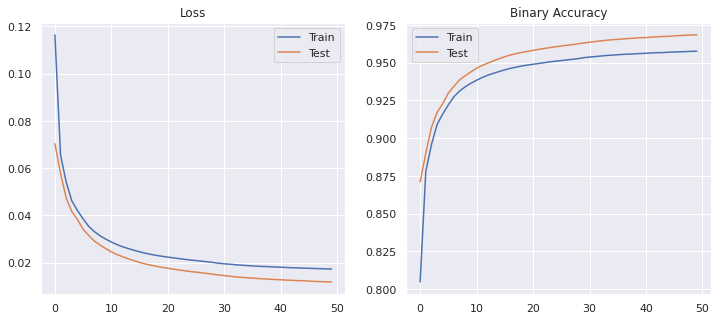

In [10]:
_, ax = plt.subplots(1, 2, figsize=(12, 5))
epochs = range(EPOCHS)

metric_plot(
    ax[0],
    'Loss',
    'loss',
    metrics
)

metric_plot(
    ax[1],
    'Binary Accuracy',
    'acc',
    metrics
)

plt.show()

Ahora podemos ver algunos resultados que da nuestro modelo, agregando ruido con distintos factores:

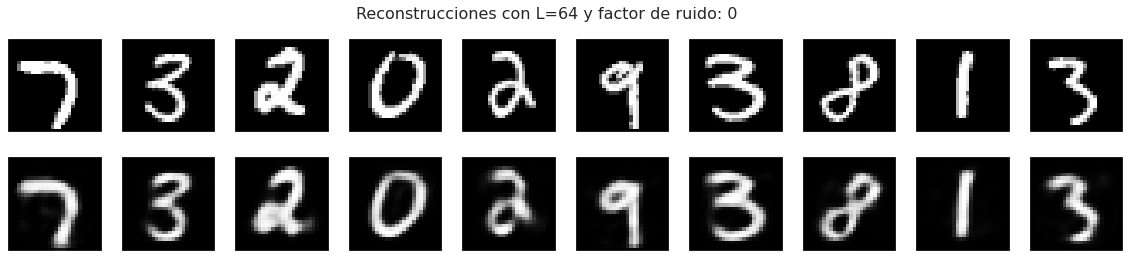

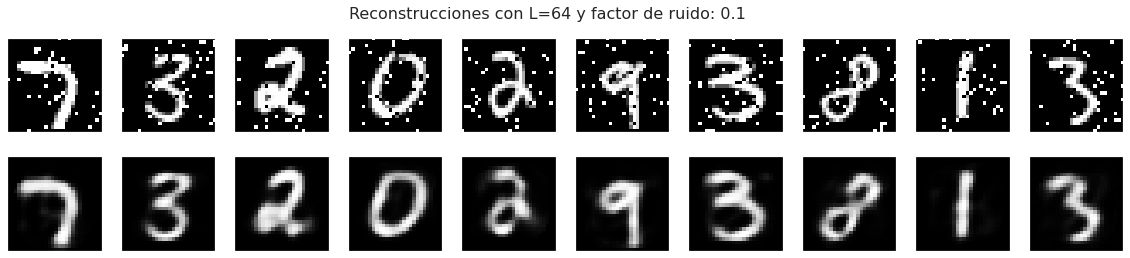

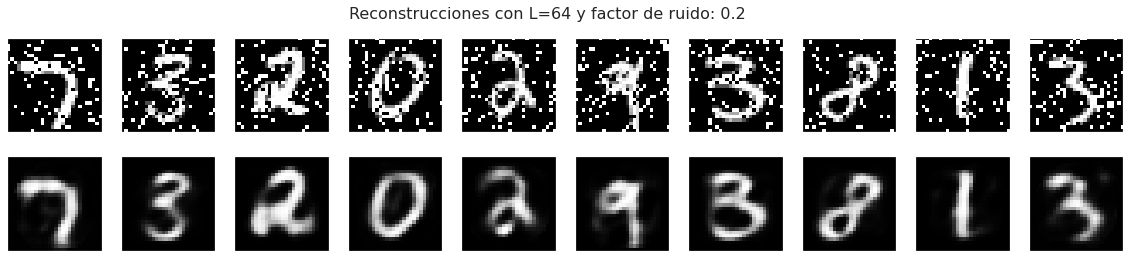

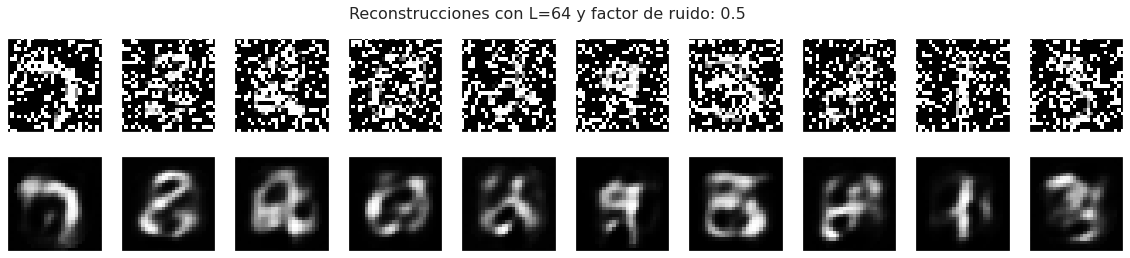

In [11]:
noise_factors = [0, 0.1, 0.2, 0.5]
test_samples = test_sample()

for noise in noise_factors:
    plot_reconstructions(
        f'Reconstrucciones con L={L} y factor de ruido: {noise}',
        model,
        test_samples,
        device,
        noise=noise
    )

### Búsqueda

Ahora, vamos a realizar una búsqueda con distintos valores para la cantidad de neuronas de la capa oculta para evaluar el comportamiento de nuestro modelo:

In [12]:
# variable hidden layer size
LS = [128, 256, 512]

# search!
search_results = []
for L in LS:
    result = train_autencoder(
        train_loader,
        test_loader,
        EPOCHS,
        LR,
        MOMENTUM,
        WEIGHT_DECAY,
        L,
        DROPOUT,
        device
    )

    search_results.append(result)

### Métricas

En esta sección, vamos a graficar las distintas métricas que obtuvimos de la búsqueda.

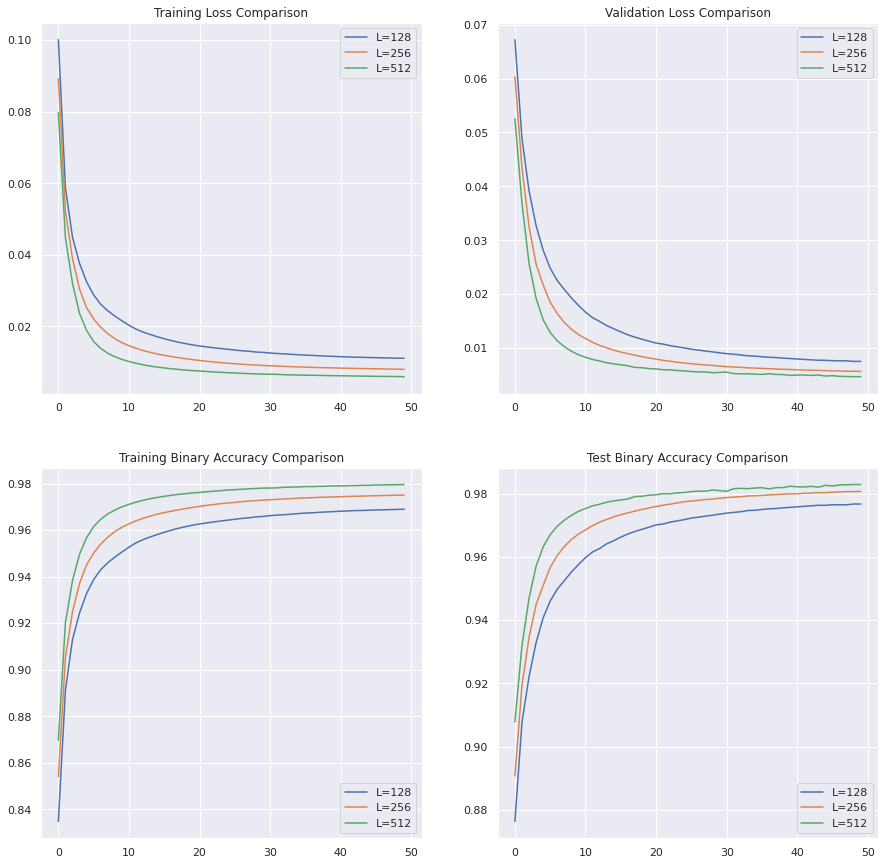

In [13]:
labels = [f'L={L}' for L in LS]

_, ax = plt.subplots(2, 2, figsize=(15, 15))
ax = ax.ravel()

search_results_metric_plot(
    ax[0],
    'Training Loss Comparison',
    'train_loss',
    search_results,
    EPOCHS,
    labels
)

search_results_metric_plot(
    ax[1],
    'Validation Loss Comparison',
    'test_loss',
    search_results,
    EPOCHS,
    labels
)

search_results_metric_plot(
    ax[2],
    'Training Binary Accuracy Comparison',
    'train_acc',
    search_results,
    EPOCHS,
    labels
)

search_results_metric_plot(
    ax[3],
    'Test Binary Accuracy Comparison',
    'test_acc',
    search_results,
    EPOCHS,
    labels
)

En estos gráficos podemos ver que mientras más neuronas tiene nuestra red oculta, más aprende nuestro modelo. Vamos a analizar la cantidad de parámetros de cada red:

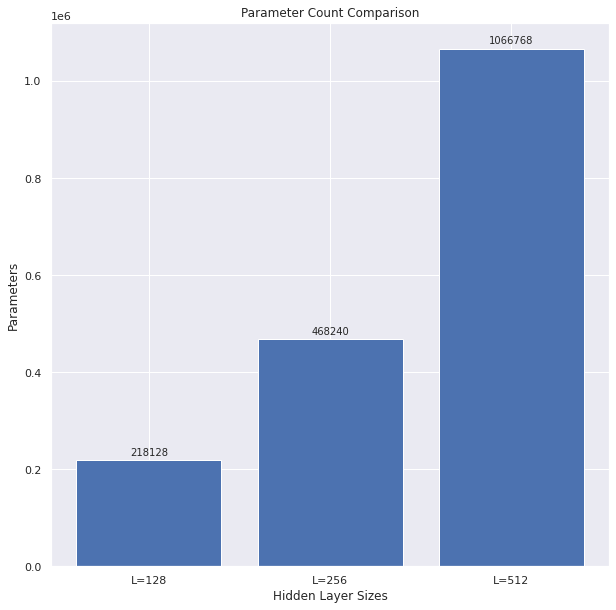

In [14]:
params_count = [
    sum(
        p.numel()
        for p in model.parameters()
        if p.requires_grad
    )
    for model, _ in search_results
]

bar_plot(
    labels,
    params_count,
    'Parameter Count Comparison',
    'Hidden Layer Sizes',
    'Parameters'
)

plt.show()

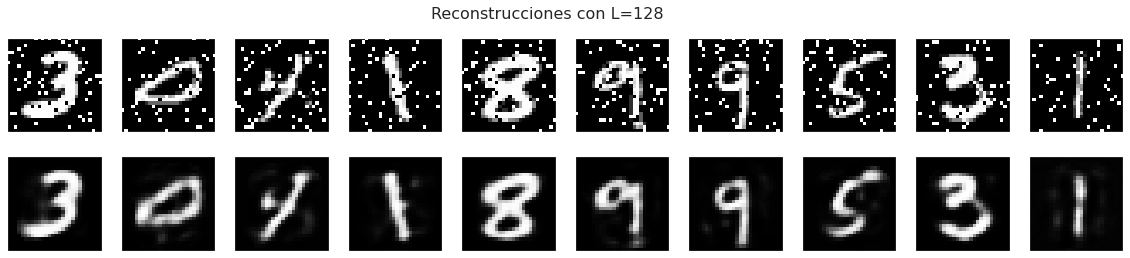

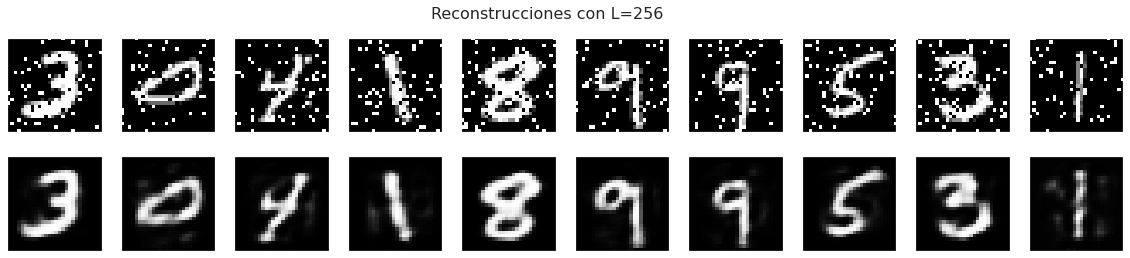

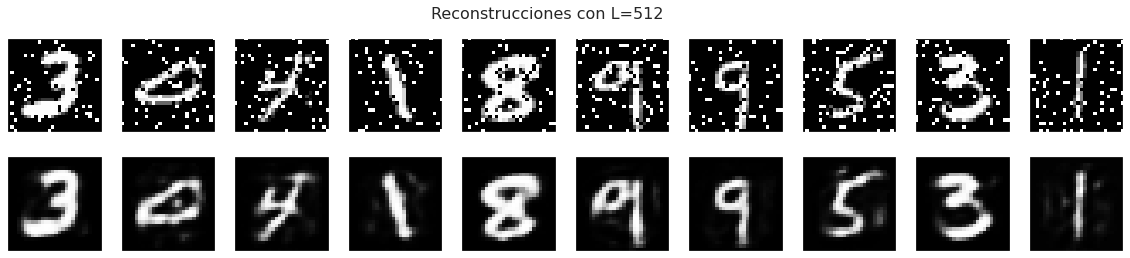

In [15]:
test_samples = test_sample()

for L, (model, _) in zip(LS, search_results):
    plot_reconstructions(
        f'Reconstrucciones con L={L}',
        model,
        test_samples,
        device,
        noise=0.15
    )